In [1]:
import sys
import argparse
import configparser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from scipy.spatial.distance import cdist
from metadata.const import features, dtypes, class_label

In [2]:
def get_config(section):
    config = configparser.RawConfigParser()
    config.read('../settings.ini')
    return dict(config.items(section))

In [3]:
def get_box_whisker_range(df):
    q1 = df.quantile(q=0.25)
    q3 = df.quantile(q=0.75)
    iqr = q3 - q1
    min_range = q1 - 1.5 * iqr
    max_range = q3 + 1.5 * iqr

    return min_range, max_range

In [4]:
def remove_zero_variance(df):
    const_filter = VarianceThreshold()
    const_filter.fit(df)
    cols = const_filter.get_support(indices=True)
    return df.iloc[:, cols]

In [5]:
def remove_category_single_value(df):
    categorical_features = df.select_dtypes(include='category').columns.tolist()
    must_remove = []
    for f in categorical_features:
        if len(df[f].unique()) == 1:
            must_remove.append(f)
    return df.drop(must_remove, axis=1)

In [6]:
def plot_correlation(correlation, filename, save=True, labels=None):
    fig = plt.figure(figsize=(10.41, 7.29))
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlation, vmin=-1, vmax=1)
    fig.colorbar(cax)
    if labels:
        ticks = np.arange(0, len(labels), 1)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)

        plt.setp(ax.get_xticklabels(), rotation=45, ha="left",
                rotation_mode="anchor")
    if save:
        plt.savefig(filename)
    else:
        plt.show()

In [7]:
filename = 'sample-200000.csv'
df = pd.read_csv(f'../dataset/{filename}', dtype=dtypes, low_memory=True)
df.drop(
    [
        features['unnamed0'],
        features['flow_id'],
        features['source_ip'],
        features['source_port'],
        features['destination_ip'],
        features['destination_port'],
        features['timestamp'],
        features['similar_http'],
    ],
    axis=1,
    inplace=True
)

In [8]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
X = df.drop(class_label, axis=1)
y = df[class_label]

In [10]:
columns = set(X.columns)
X = remove_zero_variance(X)
print(columns - set(X.columns))

{' Fwd URG Flags', ' Bwd PSH Flags', ' PSH Flag Count', ' Fwd Avg Bulk Rate', 'Fwd Avg Bytes/Bulk', ' Bwd Avg Bytes/Bulk', 'Bwd Avg Bulk Rate', ' Fwd Avg Packets/Bulk', 'FIN Flag Count', ' Bwd URG Flags', ' Bwd Avg Packets/Bulk', ' ECE Flag Count'}


In [11]:
numeric_X = X.select_dtypes(exclude='category')
corr_matrix = numeric_X.corr(method='pearson')

In [12]:
redundent_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            redundent_features.add(corr_matrix.columns[i])

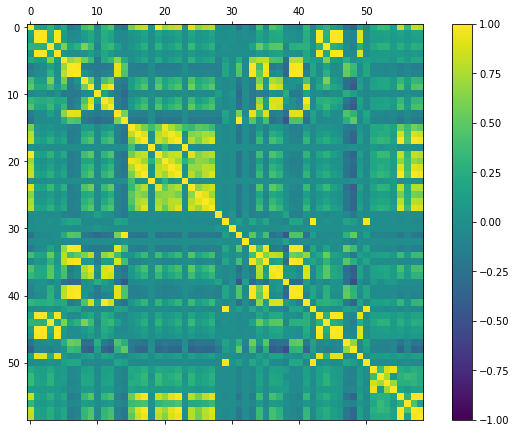

In [13]:
plot_correlation(
    corr_matrix,
    'numeric-correlation.png',
    save=False
#     labels=numeric_X.columns.to_list()
)

In [14]:
print(redundent_features)
X.drop(list(redundent_features), axis=1, inplace=True)

{' Avg Bwd Segment Size', 'Bwd IAT Total', ' Fwd Packet Length Mean', ' min_seg_size_forward', 'Subflow Fwd Packets', ' Fwd Header Length.1', ' Fwd IAT Std', ' Subflow Fwd Bytes', ' Idle Min', ' Bwd IAT Max', ' Fwd IAT Mean', ' act_data_pkt_fwd', ' Packet Length Mean', ' Active Max', ' Active Min', ' Total Backward Packets', ' Max Packet Length', ' Fwd IAT Max', ' Idle Max', ' Bwd Packet Length Mean', ' Total Length of Bwd Packets', 'Idle Mean', 'Fwd IAT Total', ' Average Packet Size', ' Subflow Bwd Packets', ' Avg Fwd Segment Size', ' Flow IAT Max', ' Flow IAT Std', ' Min Packet Length', ' Packet Length Std', ' Fwd IAT Min', ' Bwd IAT Std', ' Packet Length Variance', ' Subflow Bwd Bytes', ' Bwd Packet Length Std', 'Flow Bytes/s', 'Fwd Packets/s'}


In [15]:
scale = StandardScaler()
X_norm = scale.fit_transform(X)
print(X_norm.shape)

(194324, 30)


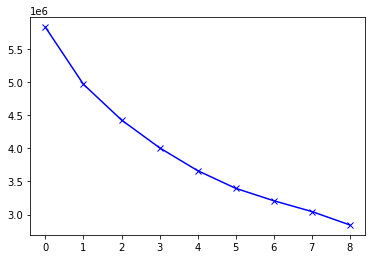

In [16]:
cost = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_norm)
    cost.append(kmeans.inertia_)
plt.plot(cost, 'bx-')

In [17]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(X_norm)
kmeans_labels = kmeans.labels_

In [18]:
pca = PCA(2)
pca.fit(X_norm)
X_PCA = pca.transform(X_norm)
X_PCA.shape

(194324, 2)

In [19]:
x_pca, y_pca = X_PCA[:, 0], X_PCA[:, 1]
colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow',
          4: 'orange',
          5: 'purple',
          6: 'pink',
          7: 'gray',
          8: 'brown'}
pca_df = pd.DataFrame({'x': x_pca, 'y': y_pca, 'label': kmeans_labels})
groups = pca_df.groupby('label')

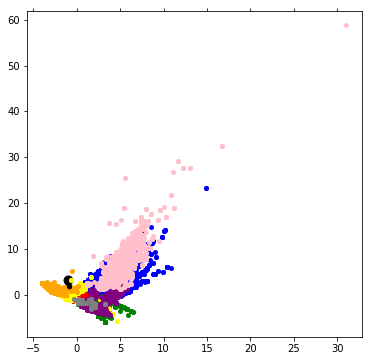

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, color='black')
plt.show()

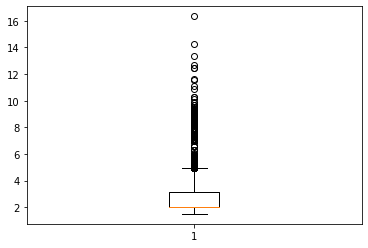

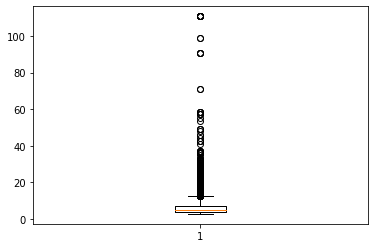

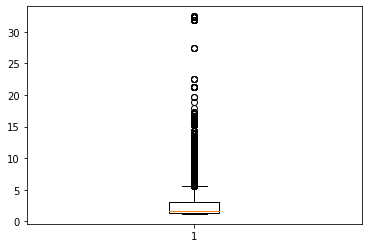

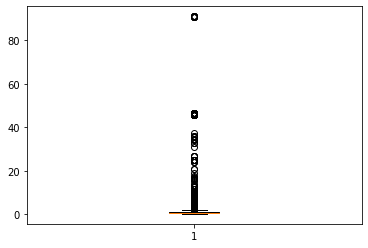

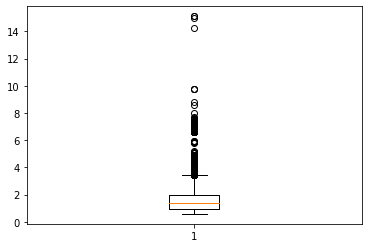

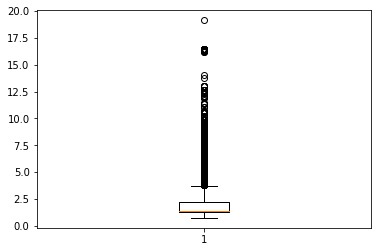

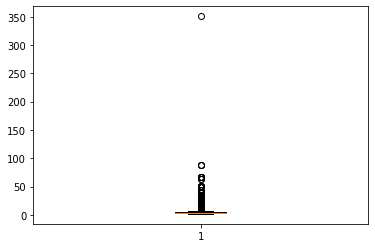

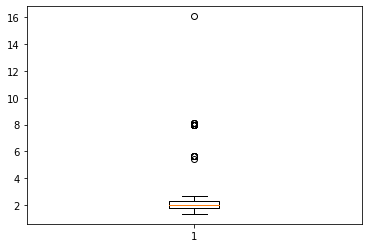

In [21]:
outliers = []
for i, center in enumerate(centroids):
    distances = cdist([center], X_norm[kmeans_labels == i], 'euclidean').ravel()
    truthness = (kmeans_labels == i)
    indices = []
    for j in range(len(truthness)):
        if truthness[j]:
            indices.append(j)
    min_range, max_range = get_box_whisker_range(pd.DataFrame({'distance': pd.Series(distances)}))
    min_range = min_range['distance']
    max_range = max_range['distance']
    for i in range(len(indices)):
        if distances[i] > max_range or distances[i] < min_range:
            outliers.append(indices[i])
    plt.boxplot(distances.tolist())
    plt.show()

In [22]:
print(len(outliers))
X.drop(outliers, axis=0, inplace=True)
y.drop(outliers, axis=0, inplace=True)

24502


In [23]:
df = pd.concat([X, y], axis=1)

In [24]:
df.to_csv(f'../dataset/clean-{filename}', index=False)